<a href="https://colab.research.google.com/github/anaizacha77/MSDS422-Group-4/blob/main/Group_4_Module_4_Assignment_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment 4**

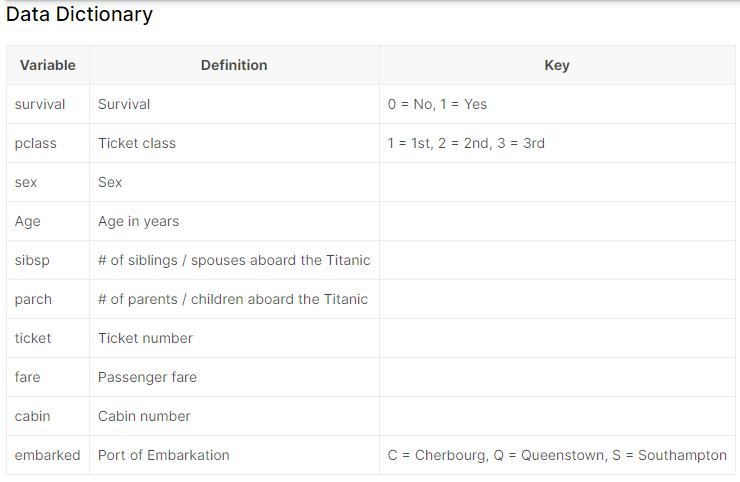

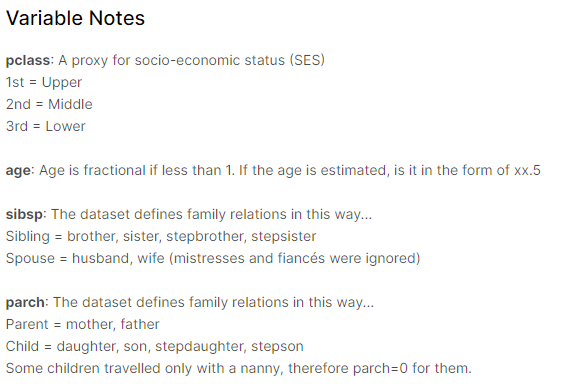

#0) Setup

In [115]:
#Import modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno

from sklearn.preprocessing import StandardScaler, MinMaxScaler,PolynomialFeatures, scale
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, precision_score, recall_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

#Set visualization style
sns.set(style="whitegrid")

In [9]:
#Must run this then select the train dataset from your local drive before running preceding code
from google.colab import files
 
uploaded = files.upload()

Saving train.csv to train (1).csv


In [10]:
import io
 
df = pd.read_csv(io.BytesIO(uploaded['train.csv']))

In [11]:
#Must run this then select the TEST dataset from your local drive before running preceding code
uploaded = files.upload()
test = pd.read_csv(io.BytesIO(uploaded['test.csv']))

Saving test.csv to test (1).csv


#1) Data Exploration and Prep

In [12]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
n=len(df)
p=len(df.columns)
print(n, p)

891 12


-Relatively few predictors, but a limited set of observations to work with as well

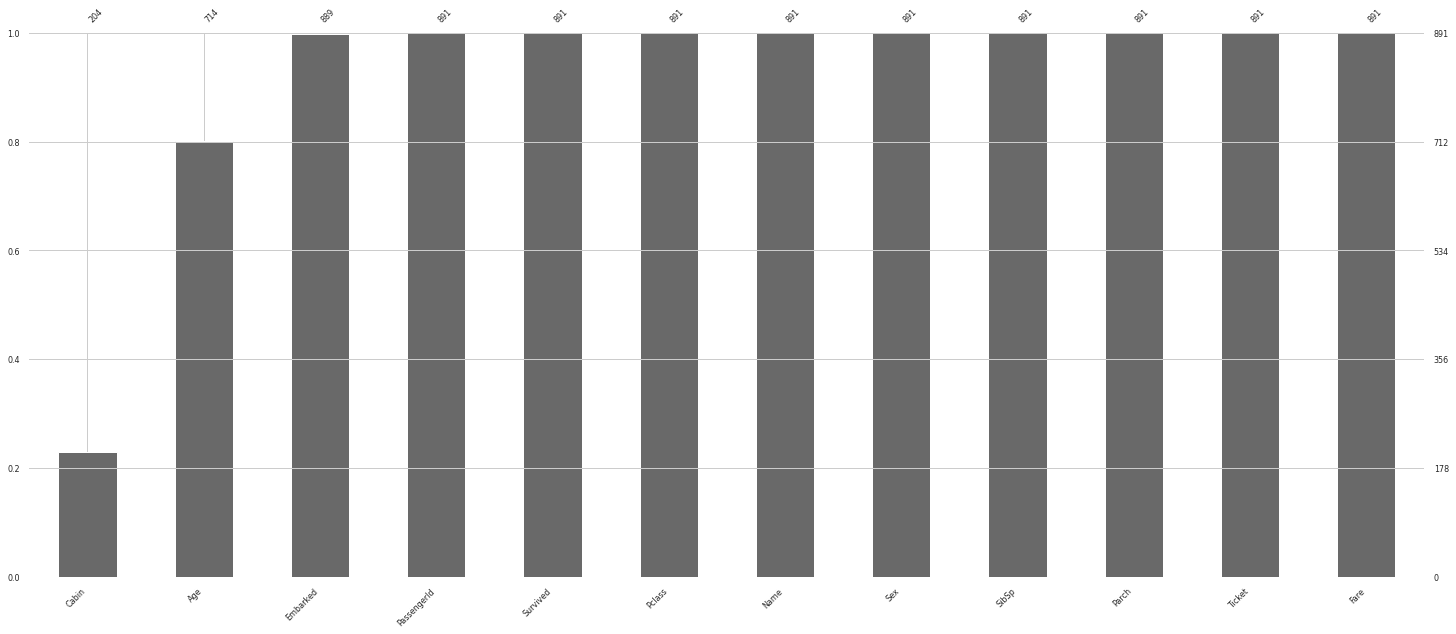

In [14]:
#visualize which variables are missing data
fig, ax=plt.subplots(figsize=(10,6))
msno.bar(df, sort='ascending', labels=True, fontsize=8);

In [15]:
#Select all non-numeric variables
cat_cols = df.select_dtypes(exclude=['int','float']).columns.to_list()

# convert list of categorical variables to a df
cat_variables = df[cat_cols]

#categorical summary
cat_variables.describe()

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [16]:
#summary statistics for numeric varaibles
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [17]:
#Initial correlation of potential predictors with Survived
df.corr()['Survived'].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

In [18]:
#Select all non-numeric variables
num_cols = df.select_dtypes(exclude=['object']).columns.to_list()
num_cols.remove('PassengerId')

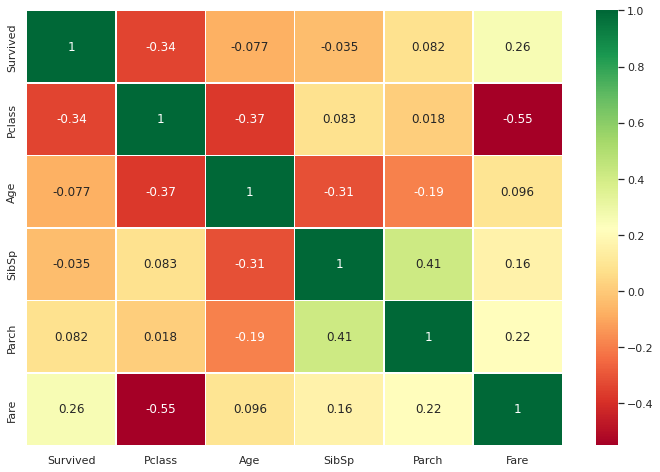

In [19]:
fig, ax=plt.subplots(figsize=(12,8))
sns.heatmap(df[num_cols].corr(),annot=True, cmap='RdYlGn', ax=ax, linewidths=.5);

In [20]:
#Survival by Sex crosstab
pd.crosstab(index=df['Sex'], columns=df['Survived'], normalize='index', margins=True)

Survived,0,1
Sex,,
female,0.257962,0.742038
male,0.811092,0.188908
All,0.616162,0.383838


In [21]:
#Survival by Fare Class crosstab
pd.crosstab(index=df['Pclass'], columns=df['Survived'], normalize='index', margins=True)

Survived,0,1
Pclass,,
1,0.370370,0.629630
2,0.527174,0.472826
3,0.757637,0.242363
All,0.616162,0.383838


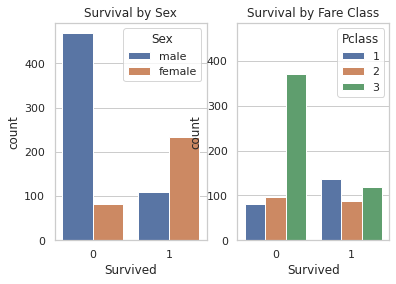

In [22]:
fig, ax =plt.subplots(1,2)
plt.ylim(0,485)
sns.countplot(data=df, x=df.Survived, hue=df.Sex,ax=ax[0]).set(title='Survival by Sex')
sns.countplot(data=df, x=df.Survived, hue=df.Pclass, ax=ax[1]).set(title='Survival by Fare Class')
plt.show()

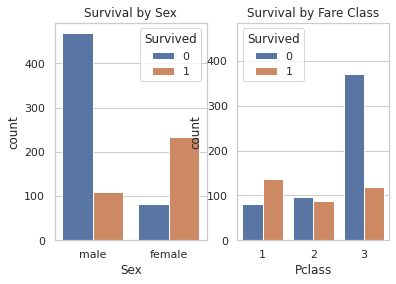

In [23]:
fig, ax =plt.subplots(1,2)
plt.ylim(0,485)
sns.countplot(data=df, x=df.Sex, hue=df.Survived,ax=ax[0]).set(title='Survival by Sex')
sns.countplot(data=df, x=df.Pclass, hue=df.Survived, ax=ax[1]).set(title='Survival by Fare Class')
plt.show()

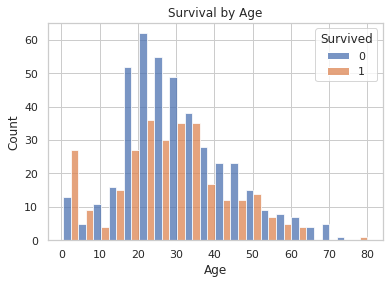

In [24]:
sns.histplot(data=df, x=df.Age, multiple='dodge', hue=df.Survived).set(title='Survival by Age');

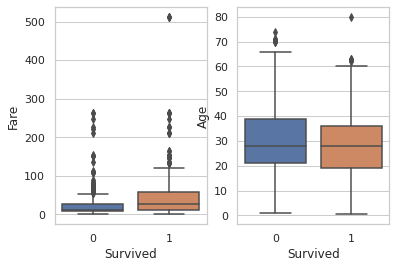

In [25]:
fig, ax =plt.subplots(1,2)
sns.boxplot(y=df.Fare, x=df.Survived, ax=ax[0])
sns.boxplot(y=df.Age, x=df.Survived, ax=ax[1])
plt.show()
#large outlier on fare price skewing the visibility of left

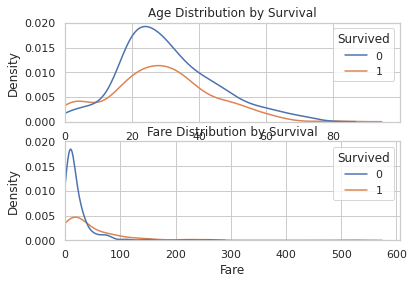

In [26]:
fig, ax =plt.subplots(2,1)
ax[0].set_ylim(0,.020)
sns.kdeplot(x=df['Age'], hue=df.Survived, ax=ax[0]).set(title='Age Distribution by Survival')
sns.kdeplot(x=df.Fare, hue=df.Survived, ax=ax[1]).set(title='Fare Distribution by Survival')
ax[0].set_xlim(xmin=0)
ax[1].set_xlim(xmin=0)
ax[0].set_ylim(0,.02)
ax[1].set_ylim(0,.02)
plt.show()

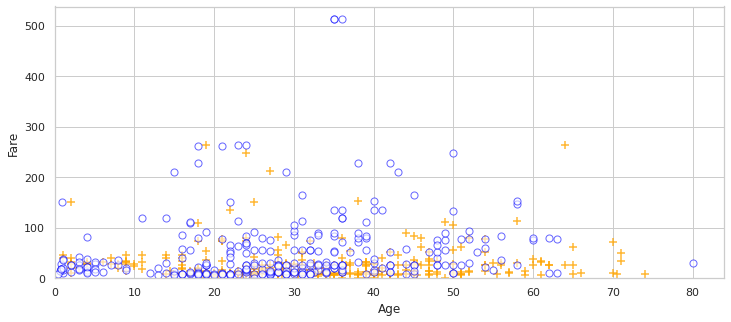

In [27]:
#Survival compared to Fare and Age
fig = plt.figure(figsize=(12,5))
plt.scatter(df[df.Survived == 0].Age, df[df.Survived == 0].Fare, s=50, c='orange', marker='+',
            linewidths=1, alpha=.8)
plt.scatter(df[df.Survived == 1].Age, df[df.Survived == 1].Fare, s=50, marker='o', linewidths='1',
            edgecolors='blue', facecolors='white', alpha=.6)
plt.ylim(ymin=0)
plt.ylabel('Fare')
plt.xlim(xmin=0)
plt.xlabel('Age')
plt.show()

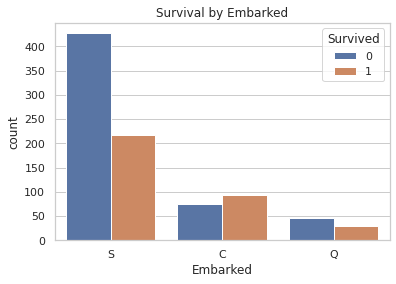

In [28]:
sns.countplot(data=df, x=df.Embarked, hue=df.Survived).set(title='Survival by Embarked');

**Observations**
- Females had a 75% survival rate, while males only had ~19%
- Lower class fares had drastically lower survival rates
- Survivors outnumbered deaths only in the youngest age bracket.
- Age has some predictive power, but decent amount of missing values
- Cabin is a mostly null field - do not use in modeling

#2) Feature Creation

In [29]:
#Create binary variable for M/F in train
df['MF_binary']=1
df.MF_binary[df.Sex=='male']=1
df.MF_binary[df.Sex=='female']=0
df.MF_binary.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


count    891.000000
mean       0.647587
std        0.477990
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: MF_binary, dtype: float64

In [30]:
#Create binary variable for M/F in test
test['MF_binary']=1
test.MF_binary[test.Sex=='male']=1
test.MF_binary[test.Sex=='female']=0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


## Age Missing Data Correction

In [31]:
#Summary of Age by other categorical variables
pd.set_option('display.max_rows',999)
df.pivot_table(values='Age', index=['Parch','Pclass'], 
               columns='Sex', aggfunc=[np.mean,np.median, 'count'],
               fill_value=0, margins=True)

mean                       median              count       \
Sex              female       male        All female  male   All female male   
Parch Pclass                                                                   
0     1       36.285714  42.506410  39.906716   35.0  42.0  38.0     56   78   
      2       32.058140  33.631250  33.081301   30.0  31.0  30.0     43   80   
      3       24.018519  28.816667  27.835227   22.0  26.0  25.5     54  210   
1     1       38.812500  44.071429  41.266667   41.5  43.5  41.5     16   14   
      2       24.666667  18.107143  21.796875   25.0  13.5  23.5     18   14   
      3       15.833333  15.497037  15.644167    9.0  14.0  11.5     21   27   
2     1       22.230769  21.615000  21.996190   22.0  18.0  21.0     13    8   
      2       20.454545  19.866000  20.270625   22.0  25.0  23.0     11    5   
      3       13.500000  10.884615  12.403226    9.5   9.0   9.0     18   13   
3     2       39.000000   0.000000  39.000000   39.0   0.0  39.0      2    0   
      3       36.000000  16.000000  29.333333   36.0  16.0  24.0      2    1   
4     1        0.000000  64.000000  64.000000    0.0  64.0  64.0      0    1   
      3       37.000000  40.000000  38.000000   37.0  40.0  40.0      2    1   
5     3       39.250000  39.000000  39.200000   39.0  39.0  39.0      4    1   
6     3       43.000000   0.000000  43.000000   43.0   0.0  43.0      1    0   
All           27.915709  30.726645  29.699118   27.0  29.0  28.0    261  453   

                   
Sex           All  
Parch Pclass       
0     1       134  
      2       123  
      3       264  
1     1        30  
      2        32  
      3        48  
2     1        21  
      2        16  
      3        31  
3     2         2  
      3         3  
4     1         1  
      3         3  
5     3         5  
6     3         1  
All           714

In [32]:
#Reduce Parch dimensionality in df and test
df['Parch_Reduced']=df['Parch']
df.Parch_Reduced[df.Parch>2]=3
test['Parch_Reduced']=test['Parch']
test.Parch_Reduced[test.Parch>2]=3
df.pivot_table(values='Age', index=['Parch_Reduced','Pclass'], columns='Sex', 
               aggfunc=[np.mean,np.median, 'count'],
               fill_value=0, margins=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


mean                       median              \
Sex                      female       male        All female  male   All   
Parch_Reduced Pclass                                                       
0             1       36.285714  42.506410  39.906716   35.0  42.0  38.0   
              2       32.058140  33.631250  33.081301   30.0  31.0  30.0   
              3       24.018519  28.816667  27.835227   22.0  26.0  25.5   
1             1       38.812500  44.071429  41.266667   41.5  43.5  41.5   
              2       24.666667  18.107143  21.796875   25.0  13.5  23.5   
              3       15.833333  15.497037  15.644167    9.0  14.0  11.5   
2             1       22.230769  21.615000  21.996190   22.0  18.0  21.0   
              2       20.454545  19.866000  20.270625   22.0  25.0  23.0   
              3       13.500000  10.884615  12.403226    9.5   9.0   9.0   
3             1        0.000000  64.000000  64.000000    0.0  64.0  64.0   
              2       39.000000   0.000000  39.000000   39.0   0.0  39.0   
              3       38.444444  31.666667  36.750000   39.0  39.0  39.0   
All                   27.915709  30.726645  29.699118   27.0  29.0  28.0   

                      count            
Sex                  female male  All  
Parch_Reduced Pclass                   
0             1          56   78  134  
              2          43   80  123  
              3          54  210  264  
1             1          16   14   30  
              2          18   14   32  
              3          21   27   48  
2             1          13    8   21  
              2          11    5   16  
              3          18   13   31  
3             1           0    1    1  
              2           2    0    2  
              3           9    3   12  
All                     261  453  714

In [33]:
#Understand Which classes and parch_reduced have Age Nulls
df[df.Age.isnull()].pivot_table(values='Age', index=['Parch_Reduced','Pclass'],
                                columns='Sex', aggfunc=['count'],
                                fill_value=0, margins=True)

count          
Sex                  female male  All
Parch_Reduced Pclass                 
0             1           0    0  NaN
              2           0    0  NaN
              3           0    0  NaN
1             1           0    0  NaN
              3           0    0  NaN
2             3           0    0  NaN
All                       0    0  0.0

In [34]:
#fill NAs using Parch_Reduced and PClass Medians
#Decided to leave Sex out
#np.logical_and limits to two arguments
df.Age[np.logical_and(df.Parch_Reduced==0,df.Pclass==1)]=df.Age[np.logical_and(
    df.Parch_Reduced==0,df.Pclass==1)].fillna(
        df.Age[np.logical_and(df.Parch_Reduced==0,df.Pclass==1)].median())
   
df.Age[np.logical_and(df.Parch_Reduced==0,df.Pclass==2)]=df.Age[np.logical_and(
    df.Parch_Reduced==0,df.Pclass==2)].fillna(
        df.Age[np.logical_and(df.Parch_Reduced==0,df.Pclass==2)].median())

df.Age[np.logical_and(df.Parch_Reduced==0,df.Pclass==3)]=df.Age[np.logical_and(
    df.Parch_Reduced==0,df.Pclass==3)].fillna(
        df.Age[np.logical_and(df.Parch_Reduced==0,df.Pclass==3)].median())

#store imputed values for test impute
a=df.Age[np.logical_and(df.Parch_Reduced==0,df.Pclass==1)].median()
b=df.Age[np.logical_and(df.Parch_Reduced==0,df.Pclass==2)].median()
c=df.Age[np.logical_and(df.Parch_Reduced==0,df.Pclass==3)].median()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [35]:
#fill NAs - part 2
df.Age[np.logical_and(df.Parch_Reduced==1,df.Pclass==1)]=df.Age[np.logical_and(
    df.Parch_Reduced==1,df.Pclass==1)].fillna(
        df.Age[np.logical_and(df.Parch_Reduced==1,df.Pclass==1)].median())
    
df.Age[np.logical_and(df.Parch_Reduced==1,df.Pclass==2)]=df.Age[np.logical_and(
    df.Parch_Reduced==1,df.Pclass==2)].fillna(
        df.Age[np.logical_and(df.Parch_Reduced==1,df.Pclass==2)].median())

df.Age[np.logical_and(df.Parch_Reduced==1,df.Pclass==3)]=df.Age[np.logical_and(
    df.Parch_Reduced==1,df.Pclass==3)].fillna(
        df.Age[np.logical_and(df.Parch_Reduced==1,df.Pclass==3)].median())

#store imputed values for test impute
d=df.Age[np.logical_and(df.Parch_Reduced==1,df.Pclass==1)].median()
e=df.Age[np.logical_and(df.Parch_Reduced==1,df.Pclass==2)].median()
f=df.Age[np.logical_and(df.Parch_Reduced==1,df.Pclass==3)].median()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [36]:
#fill NAs- part 3
df.Age[np.logical_and(df.Parch_Reduced==2,df.Pclass==1)]=df.Age[np.logical_and(
    df.Parch_Reduced==2,df.Pclass==1)].fillna(
        df.Age[np.logical_and(df.Parch_Reduced==2,df.Pclass==1)].median())
    
df.Age[np.logical_and(df.Parch_Reduced==2,df.Pclass==2)]=df.Age[np.logical_and(
    df.Parch_Reduced==2,df.Pclass==2)].fillna(
        df.Age[np.logical_and(df.Parch_Reduced==2,df.Pclass==2)].median())

df.Age[np.logical_and(df.Parch_Reduced==2,df.Pclass==3)]=df.Age[np.logical_and(
    df.Parch_Reduced==2,df.Pclass==3)].fillna(
        df.Age[np.logical_and(df.Parch_Reduced==2,df.Pclass==3)].median())
#store imputed values for test impute
h=df.Age[np.logical_and(df.Parch_Reduced==2,df.Pclass==1)].median()
i=df.Age[np.logical_and(df.Parch_Reduced==2,df.Pclass==2)].median()
j=df.Age[np.logical_and(df.Parch_Reduced==2,df.Pclass==3)].median()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [37]:
#fill NAs- part 4
df.Age[np.logical_and(df.Parch_Reduced==3,df.Pclass==1)]=df.Age[np.logical_and(
    df.Parch_Reduced==3,df.Pclass==1)].fillna(
        df.Age[np.logical_and(df.Parch_Reduced==3,df.Pclass==1)].median())
    
df.Age[np.logical_and(df.Parch_Reduced==3,df.Pclass==2)]=df.Age[np.logical_and(
    df.Parch_Reduced==3,df.Pclass==2)].fillna(
        df.Age[np.logical_and(df.Parch_Reduced==3,df.Pclass==2)].median())

df.Age[np.logical_and(df.Parch_Reduced==3,df.Pclass==3)]=df.Age[np.logical_and(
    df.Parch_Reduced==3,df.Pclass==3)].fillna(
        df.Age[np.logical_and(df.Parch_Reduced==3,df.Pclass==3)].median())
#store imputed values for test impute
k=df.Age[np.logical_and(df.Parch_Reduced==3,df.Pclass==1)].median()
l=df.Age[np.logical_and(df.Parch_Reduced==3,df.Pclass==2)].median()
m=df.Age[np.logical_and(df.Parch_Reduced==3,df.Pclass==3)].median()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [38]:
#Test - Impute missing values
test.Age[np.logical_and(test.Parch_Reduced==0,test.Pclass==1)]=test.Age[np.logical_and(
    test.Parch_Reduced==0,test.Pclass==1)].fillna(a)
   
test.Age[np.logical_and(test.Parch_Reduced==0,test.Pclass==2)]=test.Age[np.logical_and(
    test.Parch_Reduced==0,test.Pclass==2)].fillna(b)

test.Age[np.logical_and(test.Parch_Reduced==0,test.Pclass==3)]=test.Age[np.logical_and(
    test.Parch_Reduced==0,test.Pclass==3)].fillna(c)

#fill NAs - part 2
test.Age[np.logical_and(test.Parch_Reduced==1,test.Pclass==1)]=test.Age[np.logical_and(
    test.Parch_Reduced==1,test.Pclass==1)].fillna(d)
    
test.Age[np.logical_and(test.Parch_Reduced==1,test.Pclass==2)]=test.Age[np.logical_and(
    test.Parch_Reduced==1,test.Pclass==2)].fillna(e)

test.Age[np.logical_and(test.Parch_Reduced==1,test.Pclass==3)]=test.Age[np.logical_and(
    test.Parch_Reduced==1,test.Pclass==3)].fillna(f)

#fill NAs- part 3
test.Age[np.logical_and(test.Parch_Reduced==2,test.Pclass==1)]=test.Age[np.logical_and(
    test.Parch_Reduced==2,test.Pclass==1)].fillna(h)
    
test.Age[np.logical_and(test.Parch_Reduced==2,test.Pclass==2)]=test.Age[np.logical_and(
    test.Parch_Reduced==2,test.Pclass==2)].fillna(i)

test.Age[np.logical_and(test.Parch_Reduced==2,test.Pclass==3)]=test.Age[np.logical_and(
    test.Parch_Reduced==2,test.Pclass==3)].fillna(j)
#fill NAs- part 4
test.Age[np.logical_and(test.Parch_Reduced==3,test.Pclass==1)]=test.Age[np.logical_and(
    test.Parch_Reduced==3,test.Pclass==1)].fillna(k)
    
test.Age[np.logical_and(test.Parch_Reduced==3,test.Pclass==2)]=test.Age[np.logical_and(
    test.Parch_Reduced==3,test.Pclass==2)].fillna(l)

test.Age[np.logical_and(test.Parch_Reduced==3,test.Pclass==3)]=test.Age[np.logical_and(
    test.Parch_Reduced==3,test.Pclass==3)].fillna(m)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/

In [39]:
#verify all nulls addressed
df.Age.isnull().sum()

0

In [40]:
test.Age.isnull().sum()

0

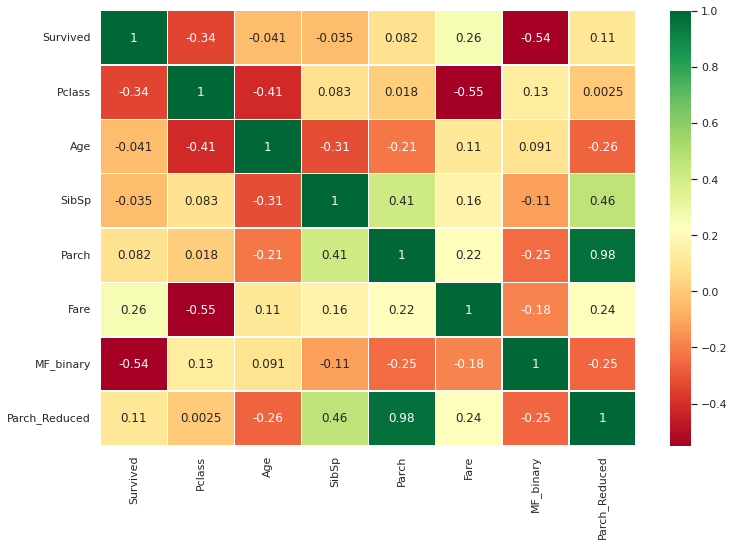

In [41]:
#re-run correlation matrix with new binary
num_cols = df.select_dtypes(exclude=['object']).columns.to_list()
num_cols.remove('PassengerId')
fig, ax=plt.subplots(figsize=(12,8))
sns.heatmap(df[num_cols].corr(),annot=True, cmap='RdYlGn', ax=ax, linewidths=.5);

#3) Logistic Regression

In [42]:
#Subset data, split into train and test
num_cols = df.select_dtypes(exclude=['object']).columns.to_list()
num_cols.remove('PassengerId')
num_cols.remove('Parch') #use Parch_Reduced instead
lr_df=df[num_cols]

#isolate X and Y
X= lr_df
X=X.drop('Survived', axis=1)
y= lr_df['Survived']

#Split into train and test
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state = 50)

In [43]:
#leverage statsmodels log regression function to view variable significance
X_train2=X_train
X_train2=sm.add_constant(X_train2) #add to fit intercept
log_reg = sm.Logit(y_train, X_train2)
res=log_reg.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.432527
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      705
Method:                           MLE   Df Model:                            6
Date:                Sun, 16 Oct 2022   Pseudo R-squ.:                  0.3440
Time:                        23:43:18   Log-Likelihood:                -307.96
converged:                       True   LL-Null:                       -469.47
Covariance Type:            nonrobust   LLR p-value:                 9.459e-67
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.3791      0.654      8.224      0.000       4.097       6.661
Pclass           -1.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


- Drop Parch_Reduced and re-run significance

In [44]:
#Drop Parch and re-run significance
log_reg = sm.Logit(y_train, X_train2[['const','Pclass', 'Age','SibSp','Fare','MF_binary']])
res=log_reg.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.432894
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      706
Method:                           MLE   Df Model:                            5
Date:                Sun, 16 Oct 2022   Pseudo R-squ.:                  0.3435
Time:                        23:43:18   Log-Likelihood:                -308.22
converged:                       True   LL-Null:                       -469.47
Covariance Type:            nonrobust   LLR p-value:                 1.446e-67
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3308      0.647      8.235      0.000       4.062       6.599
Pclass        -1.2283      0.

In [45]:
#Drop Fare and re-run significance
log_reg = sm.Logit(y_train, X_train2[['const','Age','Pclass','SibSp','MF_binary']])
res=log_reg.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.433479
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      707
Method:                           MLE   Df Model:                            4
Date:                Sun, 16 Oct 2022   Pseudo R-squ.:                  0.3426
Time:                        23:43:18   Log-Likelihood:                -308.64
converged:                       True   LL-Null:                       -469.47
Covariance Type:            nonrobust   LLR p-value:                 2.284e-68
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5866      0.583      9.579      0.000       4.444       6.730
Age           -0.0452      0.

**Observations**
- At 95% confidence interval, Age, MF_binary, SibSp, and Pclass are statistically significant.  


In [46]:
#Fit SciKit Learn LogisticRegression with all varaibles

#fit LR model
lr=LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
#predict probailities and keep for positive outcome only
lr_probs=lr.predict_proba(X_val)
lr_probs=lr_probs[:,1]
#calculate AUC scores
lr_auc=roc_auc_score(y_val, lr_probs)
print('LR: ROC AUC=%.3f' % (lr_auc))
print('Accuracy Scores: ')
cv_score=cross_val_score(lr, X_train, y_train, cv=5, scoring="accuracy")
print(cv_score)
print(cv_score.mean())

LR: ROC AUC=0.849
Accuracy Scores: 
[0.83916084 0.85314685 0.78873239 0.77464789 0.78169014]
0.8074756229685807


In [47]:
#Fit SciKit Learn LogisticRegression with Age, Pclass, SibSp, and MF_binary only
#fit LR model
lr=LogisticRegression(solver='lbfgs')
lr.fit(X_train[['Age','Pclass','SibSp','MF_binary']], y_train)
#predict probailities and keep for positive outcome only
lr_probs=lr.predict_proba(X_val[['Age','Pclass','SibSp','MF_binary']])
lr_probs=lr_probs[:,1] #probability of survival given X
#calculate AUC scores
lr_auc=roc_auc_score(y_val, lr_probs)
print('LR: ROC AUC=%.3f' % (lr_auc))
print('Accuracy Scores: ')
cv_score=cross_val_score(lr, X_train[['Age','Pclass','SibSp','MF_binary']], y_train, cv=5, scoring="accuracy")
print(cv_score)
print(cv_score.mean())

LR: ROC AUC=0.848
Accuracy Scores: 
[0.83916084 0.86713287 0.78169014 0.76056338 0.79577465]
0.8088643750615582


ROC AUC is neglibly worse for simpler model. Precede with simpler 4 variable model to visualize and optimize thresholds.

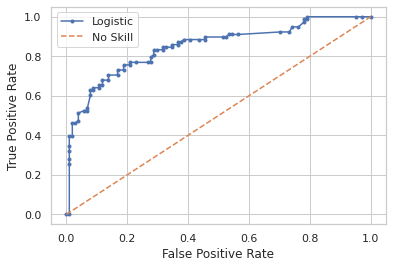

In [48]:
#ROC Curve
#generate a majority class - no skill prediction
ns_probs = [0 for _ in range(len(y_val))]
#Calculate ROC Curves
ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_val, lr_probs)
#Plot Curves
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#show legend
plt.legend()
plt.show()

In [49]:
#Predictions and Confusion Matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

#Predictions for Confusion Matrix
y_train_pred = cross_val_predict(lr, X_train[['Age','Pclass','SibSp','MF_binary']],
                                 y_train, cv=5)
confusion_matrix(y_train, y_train_pred)

array([[393,  55],
       [ 81, 183]])

In [50]:
#Precision, Recall, and F1 Score
def p_r_f1_scores(y_train, y_train_pred):
  print('Precision: ', (precision_score(y_train, y_train_pred)))
  print('Recall: ', (recall_score(y_train, y_train_pred)))
  print('F1 Score: ', f1_score(y_train, y_train_pred))

print('Train Results')
p_r_f1_scores(y_train, y_train_pred)

Train Results
Precision:  0.7689075630252101
Recall:  0.6931818181818182
F1 Score:  0.7290836653386454


In [51]:
#Validation - Precision, Recall, and F1 Score
y_val_pred=lr.predict(X_val[['Age','Pclass','SibSp','MF_binary']])

print('Validation Results')
p_r_f1_scores(y_val, y_val_pred)

Validation Results
Precision:  0.8095238095238095
Recall:  0.6538461538461539
F1 Score:  0.7234042553191489


**Observations**
- Precision and Recall fairly stable between Train and Validation.  Do not suspect overfitting.

In [52]:
#predict probability of survival - outputs 2d array [P(death), P(survival)]
y_train_pred = cross_val_predict(lr, 
                                 X_train[['Age','Pclass','SibSp','MF_binary']],
                                 y_train, cv=5, method='predict_proba')

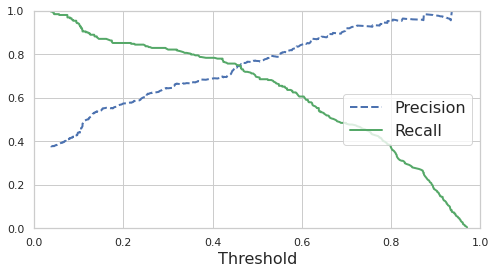

In [53]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([0, 1, 0, 1])             

precisions, recalls, thresholds = precision_recall_curve(y_train,
                                                         y_train_pred[:,1])

plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [54]:
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred[:,1])

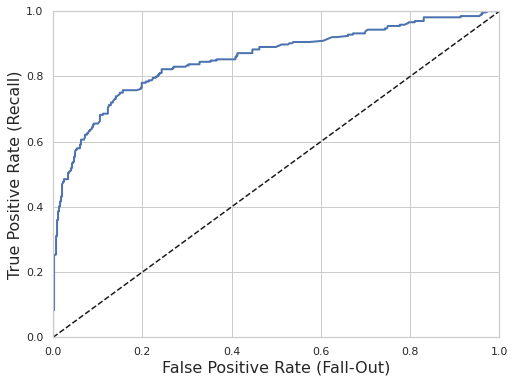

In [55]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
plt.show()

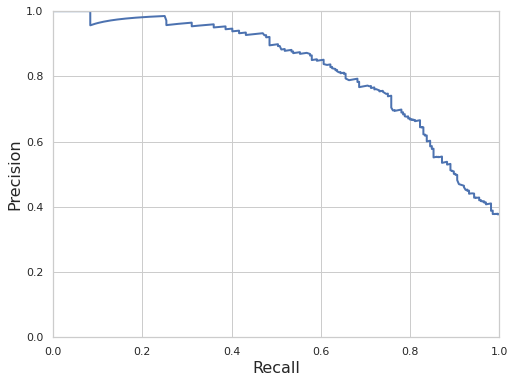

In [56]:
#Precision Recall Curve
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

##Testing Assumptions


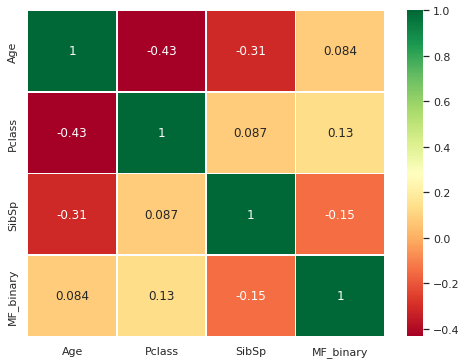

,features,vif_Factor
0,Pclass,4.428255
1,Age,4.113532
2,SibSp,1.671393
3,Fare,1.777846
4,MF_binary,3.094347
5,Parch_Reduced,1.725696


In [57]:
#Log Regression Assumptions
#1) little to no multicollinearity among the independent variables
#Investigate with correlation matrix 
feats=['Age','Pclass','SibSp','MF_binary']
fig, ax=plt.subplots(figsize=(8,6))
sns.heatmap(X_train[feats].corr(),annot=True, cmap='RdYlGn', ax=ax, linewidths=.5);
plt.show()

#Investigate with Variance Inflation Factor - Over 10 suggests multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["features"] = X_train.columns
vif["vif_Factor"] = [variance_inflation_factor(X_train.values, i) for
                     i in range(X_train.shape[1])]
vif
#No multicollinearity exists.

In [58]:
#2) Assumes linearity of independent variables and log odds
#Perform Box-Tidwell Test ONLY on continuous variables

#Clone X train dataset
X_lt=X_train[feats]
feats3=['Age'] #Age is only continuous variable

# Add logit transform interaction terms (natural log) 
#for continuous variables e.g.. Age * Log(Age)
#below is overkill since one variable, but in case more continuous variables in future
for var in feats3:      
    X_lt[f'{var}:Log_{var}'] = X_lt[var].apply(lambda x: x * np.log(x))

#Add constant term
X_lt=sm.add_constant(X_lt) #add to fit intercept


log_reg = sm.Logit(y_train, X_lt)
res=log_reg.fit()
print(res.summary())


Optimization terminated successfully.
         Current function value: 0.429025
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      706
Method:                           MLE   Df Model:                            5
Date:                Sun, 16 Oct 2022   Pseudo R-squ.:                  0.3493
Time:                        23:43:23   Log-Likelihood:                -305.47
converged:                       True   LL-Null:                       -469.47
Covariance Type:            nonrobust   LLR p-value:                 9.443e-69
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.7530      0.777      8.691      0.000       5.230       8.276
Age            -0.2560    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Since Age:Log_Age is statistically significant at alpha =.05, this indicates the presence of non-linearity between Age and the logit. Fails assumption.

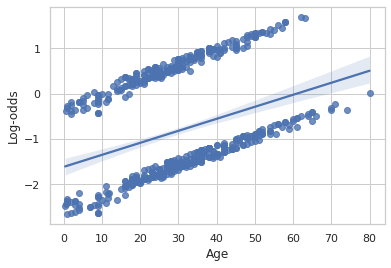

In [59]:
#Visual inspection of Age linearity vs log-odds
log_reg=sm.GLM(y_train, X_train2[feats], family=sm.families.Binomial()).fit()
predicted=log_reg.predict(X_train2[feats])

# Getting log odds values
log_odds = np.log(predicted / (1 - predicted))

sns.regplot(x=X_train2['Age'].values, y=log_odds)
plt.xlabel("Age")
plt.ylabel("Log-odds")
plt.show()

Visual inspection does not support the non-linearity.  Assumption preserved

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,cooks_d,std_resid
261,0.029630,3.458713
803,0.011854,3.249107
348,0.010538,3.206356
869,0.010128,3.158822
755,0.009039,3.153723
831,0.008981,3.146193
340,0.008573,3.091659
407,0.008237,3.045778
193,0.008237,3.045778
78,0.008228,3.067586


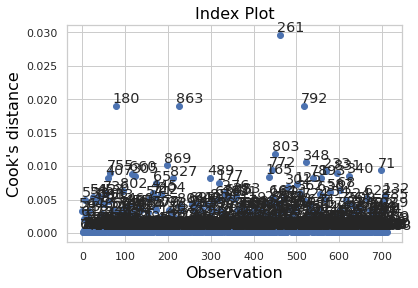

In [60]:
# Get influence measures
influence = log_reg.get_influence()

#Plot influence
influence.plot_index()

# Obtain summary df of influence measures
summ_df = influence.summary_frame()

# Filter summary df to Cook's distance values only
diagnosis_df = summ_df[['cooks_d']]

# Set Cook's distance threshold
cook_threshold = 4 / len(X_train)

# Append absolute standardized residual values 
diagnosis_df['std_resid'] = stats.zscore(log_reg.resid_pearson)
diagnosis_df['std_resid'] = diagnosis_df['std_resid'].apply(lambda x: np.abs(x))

# Find observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[(diagnosis_df['cooks_d'] > cook_threshold) & 
                       (diagnosis_df['std_resid'] > 3)]

# Show highly influential outlier observations
extreme.sort_values("cooks_d", ascending=False)

- 11 values identified as influential outliers
- Dropped influential outliers, re-trained Logistic Regression model, but so no material improvement in predictive accuracy

# 4) KNN 

In [61]:
# create copy of original df
df2 = df
# df_knn = training set used for knn model
# need to remove Parch and Sex since we already derived features from them and also Name, Ticket, Cabin 
df_knn=df2.drop(['Sex','Parch','PassengerId','Name','Ticket', 'Cabin'], axis=1)

df_knn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Survived       891 non-null    int64  
 1   Pclass         891 non-null    int64  
 2   Age            891 non-null    float64
 3   SibSp          891 non-null    int64  
 4   Fare           891 non-null    float64
 5   Embarked       889 non-null    object 
 6   MF_binary      891 non-null    int64  
 7   Parch_Reduced  891 non-null    int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 55.8+ KB


In [62]:
# create dummy variables for train set
# first will change data type for Survided and Pclass to object
df_knn['Survived'] = df_knn['Survived'].apply(str)
df_knn['Pclass'] = df_knn['Pclass'].apply(str)
df_knn['MF_binary'] = df_knn['MF_binary'].apply(str)

In [63]:
df_knn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Survived       891 non-null    object 
 1   Pclass         891 non-null    object 
 2   Age            891 non-null    float64
 3   SibSp          891 non-null    int64  
 4   Fare           891 non-null    float64
 5   Embarked       889 non-null    object 
 6   MF_binary      891 non-null    object 
 7   Parch_Reduced  891 non-null    int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 55.8+ KB


In [64]:
# second I will seperate features by data type
df_knn_train_num = df_knn.select_dtypes(exclude='object')
df_knn_train_obj = df_knn.select_dtypes(include='object')

In [65]:
df_knn_train_obj.drop('Survived', axis = 1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [66]:
df_knn_train_obj = pd.get_dummies(df_knn_train_obj, drop_first=True)

In [67]:
df_knn_train_final = pd.concat([df_knn_train_num, df_knn_train_obj,df_knn['Survived']], axis=1)

df_knn_train_final.head()

,Age,SibSp,Fare,Parch_Reduced,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,MF_binary_1,Survived
0,22.0,1,7.2500,0,0,1,0,1,1,0
1,38.0,1,71.2833,0,0,0,0,0,0,1
2,26.0,0,7.9250,0,0,1,0,1,0,1
3,35.0,1,53.1000,0,0,0,0,1,0,1
4,35.0,0,8.0500,0,0,1,0,1,1,0


In [68]:
#isolate X and Y
X2= df_knn_train_final
X2=X2.drop('Survived', axis=1)
y2= df_knn_train_final['Survived']

#Split into train and test
X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y2, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state = 50)

In [69]:
# scale data
scaler= StandardScaler()

scaler.fit(X2_train)

StandardScaler()

In [70]:
scaled_X_train= scaler.transform(X2_train)
scaled_X_test= scaler.transform(X2_val)

In [71]:
# build model
knn_model= KNeighborsClassifier(n_neighbors=1)

In [72]:
knn_model.fit(scaled_X_train, y2_train)

KNeighborsClassifier(n_neighbors=1)

In [73]:
y_pred= knn_model.predict(scaled_X_test)

In [74]:
actual_vs_predicted = pd.DataFrame({'Y_Test':y2_val, 'Y_Pred': y_pred})
actual_vs_predicted

,Y_Test,Y_Pred
558,1,1
547,1,0
494,0,0
679,1,1
7,0,0
248,1,0
222,0,0
589,0,0
356,1,1
315,1,0


In [75]:
# evaluate model
#Predictions for Confusion Matrix

confusion_matrix(y2_val, y_pred)

array([[84, 17],
       [28, 50]])

In [76]:
print(classification_report(y2_val, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.83      0.79       101
           1       0.75      0.64      0.69        78

    accuracy                           0.75       179
   macro avg       0.75      0.74      0.74       179
weighted avg       0.75      0.75      0.75       179



To make this model better I will try to find out which value of K is the optimal one

In [77]:
test_error_rate= []

for k in range (1, 30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(scaled_X_train, y2_train)
    
    y_pred_test = knn_model.predict(scaled_X_test)
    
    test_error=1- accuracy_score(y2_val, y_pred_test)
    test_error_rate.append(test_error)

In [78]:
# creates an error rate score for each value of K based on the data
test_error_rate

[0.25139664804469275,
 0.26815642458100564,
 0.2178770949720671,
 0.2178770949720671,
 0.2122905027932961,
 0.2178770949720671,
 0.2067039106145251,
 0.22346368715083798,
 0.2122905027932961,
 0.2178770949720671,
 0.22905027932960897,
 0.22346368715083798,
 0.22346368715083798,
 0.23463687150837986,
 0.22905027932960897,
 0.24022346368715086,
 0.25139664804469275,
 0.24022346368715086,
 0.24581005586592175,
 0.24581005586592175,
 0.24581005586592175,
 0.25139664804469275,
 0.25139664804469275,
 0.24581005586592175,
 0.25139664804469275,
 0.25139664804469275,
 0.24581005586592175,
 0.24022346368715086,
 0.24581005586592175]

Text(0.5, 0, 'K Value')

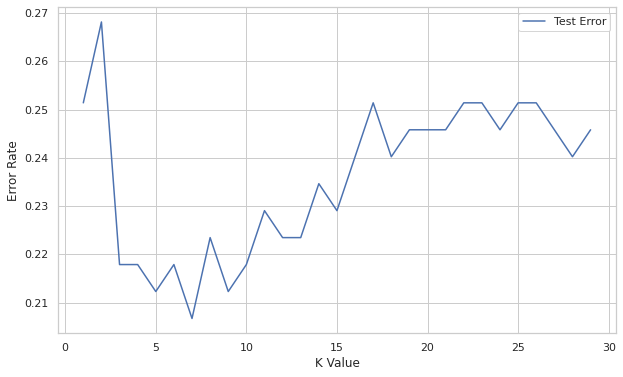

In [79]:
# visualize the above K values and accuracy scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, 30), test_error_rate, label='Test Error')
plt.legend()
plt.ylabel('Error Rate')
plt.xlabel('K Value')

Based on the chart above I will use a K = 7 and see how the model performs

In [80]:
# build model # 2 with new K value
knn_model2= KNeighborsClassifier(n_neighbors=7)

In [81]:
knn_model2.fit(scaled_X_train, y2_train)

KNeighborsClassifier(n_neighbors=7)

In [82]:
y_pred2= knn_model2.predict(scaled_X_test)

In [83]:
actual_vs_predicted = pd.DataFrame({'Y_Test':y2_val, 'Y_Pred': y_pred2})

In [84]:
#Predictions for Confusion Matrix 2
confusion_matrix(y2_val, y_pred2)

array([[92,  9],
       [28, 50]])

In [85]:
print(classification_report(y2_val, y_pred2))

              precision    recall  f1-score   support

           0       0.77      0.91      0.83       101
           1       0.85      0.64      0.73        78

    accuracy                           0.79       179
   macro avg       0.81      0.78      0.78       179
weighted avg       0.80      0.79      0.79       179



By comparing the second model that used a value of k=7 vs our first model that used a k = 1 our performance improved a lot for all metrics

#Export to Kaggle

Logistic Regression

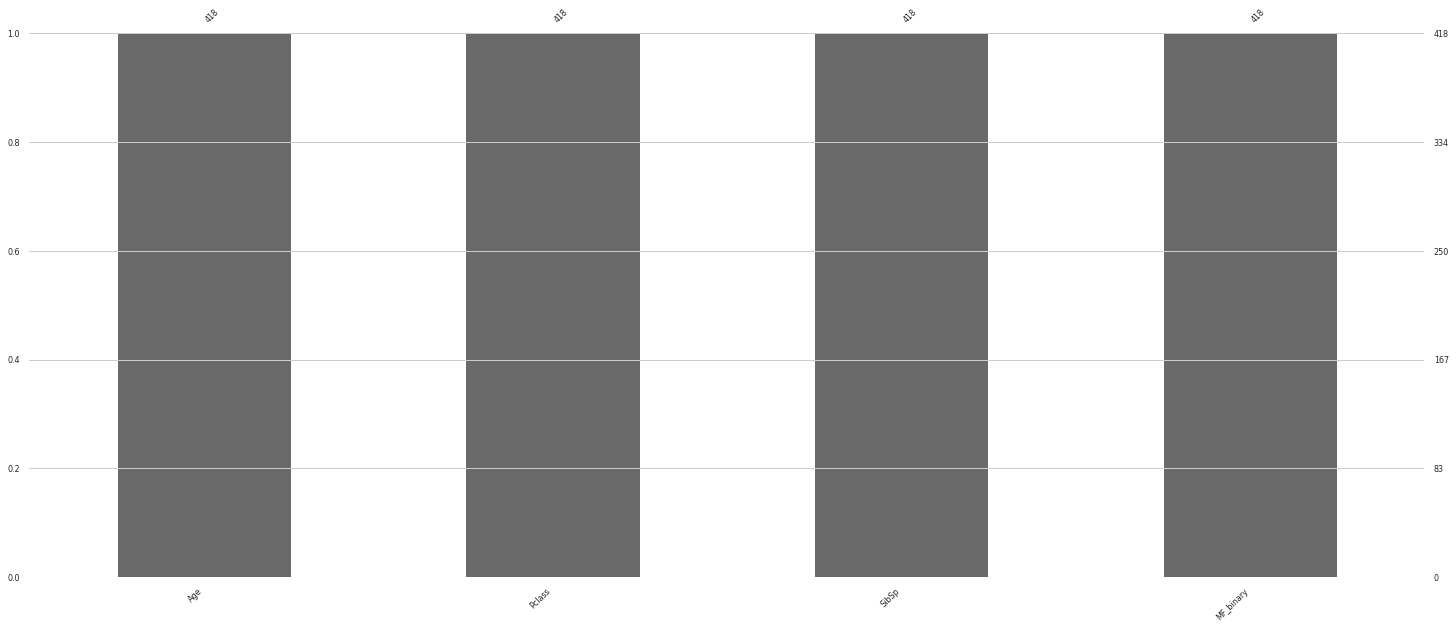

In [86]:
#Isolate Features
feats=['Age','Pclass','SibSp','MF_binary']
test_log_reg=test[feats]

#Verify no nulls
fig, ax=plt.subplots(figsize=(10,6))
msno.bar(test_log_reg, sort='ascending', labels=True, fontsize=8);

In [87]:
#Apply Log Regression
test_log_reg['Survived']=lr.predict(test_log_reg);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [88]:
#prepare data for extract and upload to kaggle
id=test['PassengerId']
test_log_reg.insert(0, 'PassengerId', id)
test_log_reg=test_log_reg[['PassengerId','Survived']]
test_log_reg.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [89]:
#Download
test_log_reg.to_csv('log_output.csv', encoding = 'utf-8-sig', index=False)
files.download('log_output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Log Reg Output Kaggle Score - .76315 (1.0 is max this time)

KNN 

In [90]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    418 non-null    int64  
 1   Pclass         418 non-null    int64  
 2   Name           418 non-null    object 
 3   Sex            418 non-null    object 
 4   Age            418 non-null    float64
 5   SibSp          418 non-null    int64  
 6   Parch          418 non-null    int64  
 7   Ticket         418 non-null    object 
 8   Fare           417 non-null    float64
 9   Cabin          91 non-null     object 
 10  Embarked       418 non-null    object 
 11  MF_binary      418 non-null    int64  
 12  Parch_Reduced  418 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 42.6+ KB


In [91]:
# modify test set as train set
test2 = test

df_knn_test=test2.drop(['Sex','PassengerId','Name','Ticket', 'Cabin', 'Parch'], axis=1)

df_knn_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pclass         418 non-null    int64  
 1   Age            418 non-null    float64
 2   SibSp          418 non-null    int64  
 3   Fare           417 non-null    float64
 4   Embarked       418 non-null    object 
 5   MF_binary      418 non-null    int64  
 6   Parch_Reduced  418 non-null    int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 23.0+ KB


In [92]:
df_knn_test.isnull().sum()

Pclass           0
Age              0
SibSp            0
Fare             1
Embarked         0
MF_binary        0
Parch_Reduced    0
dtype: int64

In [93]:
# will replace null valu of Fare with median value of Fare
df_knn_test['Fare'] = df_knn_test['Fare'].fillna(df_knn_test['Fare'].median())

In [94]:
df_knn_test.isnull().sum()

Pclass           0
Age              0
SibSp            0
Fare             0
Embarked         0
MF_binary        0
Parch_Reduced    0
dtype: int64

In [95]:
# will input the median age value to all values in age column that are null
df_knn_test['Age'] = df_knn_test['Age'].fillna(df_knn_test['Age'].median())
df_knn_test.isnull().sum()

Pclass           0
Age              0
SibSp            0
Fare             0
Embarked         0
MF_binary        0
Parch_Reduced    0
dtype: int64

In [96]:
df_knn_test['Pclass'] = df_knn_test['Pclass'].apply(str)
df_knn_test['MF_binary'] = df_knn_test['MF_binary'].apply(str)

In [97]:
df_knn_testset_num = df_knn_test.select_dtypes(exclude='object')
df_knn_testset_obj = df_knn_test.select_dtypes(include='object')

In [98]:
df_knn_testset_obj = pd.get_dummies(df_knn_testset_obj, drop_first=True)

In [99]:
df_knn_testset_final = pd.concat([df_knn_testset_num, df_knn_testset_obj], axis=1)

In [100]:
# scale test set
scaled_X_testset_final= scaler.transform(df_knn_testset_final)

In [101]:
# apply model to test set
knn_predictions = knn_model2.predict(scaled_X_testset_final)

In [102]:
test_knn_model = pd.DataFrame()
test_knn_model['Survived'] = knn_predictions

In [103]:
#prepare data for extract and upload to kaggle
id=test['PassengerId']
test_knn_model.insert(0, 'PassengerId', id)
test_knn_model=test_knn_model[['PassengerId','Survived']]
test_knn_model.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [104]:
#Download
test_knn_model.to_csv('test_knn_model.csv', encoding = 'utf-8-sig', index=False)
files.download('test_knn_model.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNN Output Kaggle Score = 0.75119

# 5) LDA 


In [111]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt

from sklearn import metrics 
from sklearn import datasets
from sklearn.model_selection import train_test_split 
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

In [106]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,MF_binary,Parch_Reduced
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,0


In [107]:
#Subset data, split into train and test
#Model for all suitable varabiles 
num_col_lda = ['Survived','Age','Pclass','SibSp','MF_binary','Parch_Reduced','Fare','Parch']
df_lda = df[num_col_lda]

#isolate X and Y
X= df_lda[num_col_lda]
X=X.drop('Survived', axis=1)
y= df_lda['Survived']

#Split into train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state = 50)

In [108]:
print('x_train:',x_train.shape,'y_train:',y_train.shape)
print('x_test:',x_test.shape,'y_test:',y_test.shape)

x_train: (712, 7) y_train: (712,)
x_test: (179, 7) y_test: (179,)


In [116]:
#LDA 
clf =LinearDiscriminantAnalysis()
clf.fit(x_train,y_train)

y_pred = clf.predict(x_test)

#accuracy test 
acc = metrics.accuracy_score(y_test,y_pred)
print(f'accuracy:',acc)


accuracy: 0.7877094972067039


confusion matrix:
 [[88 13]
 [25 53]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


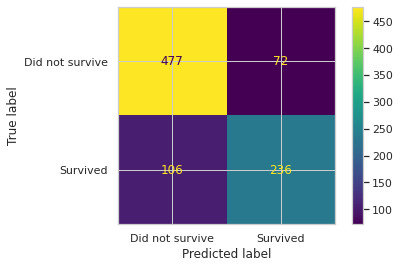

In [117]:
#confusion test 
con = metrics.confusion_matrix(y_test,y_pred)
print(f'confusion matrix:\n',con)

#confusion matrix plot
plot_confusion_matrix(estimator=clf,
                      X=X,
                      y_true=y,
                      display_labels=["Did not survive", "Survived"])

In [118]:
#Subset data, split into train and test
#Model for statiscally significant varabiles from Log. Regression Model
num_col_lda = ['Survived','Age','Pclass','SibSp','MF_binary']
df_lda = df[num_col_lda]

#isolate X and Y
X= df_lda[num_col_lda]
X=X.drop('Survived', axis=1)
y= df_lda['Survived']

#Split into train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state = 50)

In [119]:
print('x_train:',x_train.shape,'y_train:',y_train.shape)
print('x_test:',x_test.shape,'y_test:',y_test.shape)

x_train: (712, 4) y_train: (712,)
x_test: (179, 4) y_test: (179,)


In [120]:
#LDA 
clf_ss =LinearDiscriminantAnalysis()
clf_ss.fit(x_train,y_train)

y_pred = clf_ss.predict(x_test)

#accuracy test 
acc = metrics.accuracy_score(y_test,y_pred)
print(f'accuracy:',acc)


accuracy: 0.7821229050279329


confusion matrix:
 [[88 13]
 [26 52]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


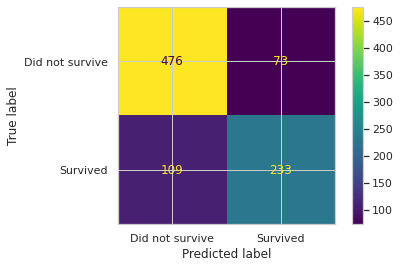

In [121]:
#confusion test 
con = metrics.confusion_matrix(y_test,y_pred)
print(f'confusion matrix:\n',con)

#confusion matrix plot
plot_confusion_matrix(estimator=clf_ss,
                      X=X,
                      y_true=y,
                      display_labels=["Did not survive", "Survived"])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


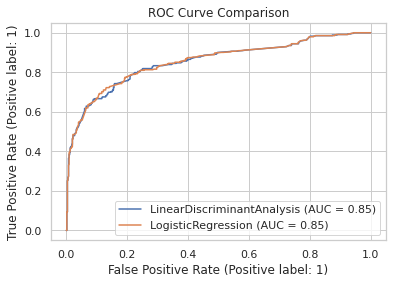

In [122]:
#LDA vs. Log. Regression ROC Curve Comparison
roc_lda = plot_roc_curve(estimator=clf_ss, X=X, y=y)
roc_log_reg = plot_roc_curve(estimator=lr, X=X, y=y, ax=roc_lda.ax_)
plt.title("ROC Curve Comparison")
plt.show()

The ROC Curve comparison between the Logistic regression model and Linear Discrimination Analysis model are similar and difference is negligable.

In [123]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    418 non-null    int64  
 1   Pclass         418 non-null    int64  
 2   Name           418 non-null    object 
 3   Sex            418 non-null    object 
 4   Age            418 non-null    float64
 5   SibSp          418 non-null    int64  
 6   Parch          418 non-null    int64  
 7   Ticket         418 non-null    object 
 8   Fare           417 non-null    float64
 9   Cabin          91 non-null     object 
 10  Embarked       418 non-null    object 
 11  MF_binary      418 non-null    int64  
 12  Parch_Reduced  418 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 42.6+ KB


In [127]:
# filter test set to only include variables used to build the model
test_num_col_lda = ['Age','Pclass','SibSp','MF_binary']
test_df_lda = test[test_num_col_lda]

test_df_lda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        418 non-null    float64
 1   Pclass     418 non-null    int64  
 2   SibSp      418 non-null    int64  
 3   MF_binary  418 non-null    int64  
dtypes: float64(1), int64(3)
memory usage: 13.2 KB


In [128]:
# apply model to test set 
y_pred_test_set = clf_ss.predict(test_df_lda)

In [129]:
# export to kaggle
test_lda_model = pd.DataFrame()
test_lda_model['Survived'] = y_pred_test_set

In [130]:
#prepare data for extract and upload to kaggle
id=test['PassengerId']
test_lda_model.insert(0, 'PassengerId', id)
test_lda_model=test_lda_model[['PassengerId','Survived']]
test_lda_model.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [131]:
#Download
test_lda_model.to_csv('test_lda_model.csv', encoding = 'utf-8-sig', index=False)
files.download('test_lda_model.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LDA Output Kaggle Score = 0.76555